In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload

import celeri

plt.rcParams["text.usetex"] = False

# Read in data files, create storage dictionaries, and do basic processing

In [3]:
# Western North America example
command_file_name = "../data/command/japan_command.json"

In [4]:
command = celeri.get_command(command_file_name)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(
    assembly, station, sar
)  # Not sure this works correctly

2024-10-25 15:58:26.376 | INFO     | celeri.celeri:get_logger:7493 - Read: ../data/command/japan_command.json
2024-10-25 15:58:26.377 | INFO     | celeri.celeri:get_logger:7494 - RUN_NAME: 0000000107
2024-10-25 15:58:26.378 | INFO     | celeri.celeri:get_logger:7495 - Write log file: ../runs/0000000107/0000000107.log
2024-10-25 15:58:26.378 | INFO     | celeri.celeri:read_data:451 - Reading data files
2024-10-25 15:58:26.384 | SUCCESS  | celeri.celeri:read_data:455 - Read: ../data/segment/qp_japan_segment.csv
2024-10-25 15:58:26.386 | SUCCESS  | celeri.celeri:read_data:460 - Read: ../data/block/japan_block.csv
2024-10-25 15:58:26.387 | SUCCESS  | celeri.celeri:read_data:467 - Read: ../data/mesh/japan_mesh_parameters.json

2024-10-25 15:58:26.463 | SUCCESS  | celeri.celeri:read_mesh:446 - Read: ../data/mesh/nankai.msh

2024-10-25 15:58:26.472 | SUCCESS  | celeri.celeri:read_mesh:446 - Read: ../data/mesh/japan.msh

2024-10-25 15:58:26.487 | SUCCESS  | celeri.celeri:read_mesh:446 - Read: 

# Get elastic operators and TDE smoothing operators

In [5]:
command.reuse_elastic = 0

# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

2024-10-25 15:58:26.970 | INFO     | celeri.celeri:get_elastic_operators:2053 - Computing elastic operators


Calculating Okada partials for segments: 100%|██████████| 481/481 [00:08<00:00, 55.53it/s]

2024-10-25 15:58:35.683 | INFO     | celeri.celeri:get_elastic_operators:2061 - Start: TDE slip to velocity calculation for mesh: ../data/mesh/nankai.msh



Calculating cutde partials for triangles: 100%|██████████| 1902/1902 [00:06<00:00, 291.17it/s]

2024-10-25 15:58:42.217 | SUCCESS  | celeri.celeri:get_elastic_operators:2067 - Finish: TDE slip to velocity calculation for mesh: ../data/mesh/nankai.msh
2024-10-25 15:58:42.218 | INFO     | celeri.celeri:get_elastic_operators:2061 - Start: TDE slip to velocity calculation for mesh: ../data/mesh/japan.msh



Calculating cutde partials for triangles: 100%|██████████| 2621/2621 [00:08<00:00, 297.52it/s]

2024-10-25 15:58:51.030 | SUCCESS  | celeri.celeri:get_elastic_operators:2067 - Finish: TDE slip to velocity calculation for mesh: ../data/mesh/japan.msh
2024-10-25 15:58:51.030 | INFO     | celeri.celeri:get_elastic_operators:2061 - Start: TDE slip to velocity calculation for mesh: ../data/mesh/sagami.msh



Calculating cutde partials for triangles: 100%|██████████| 231/231 [00:00<00:00, 304.28it/s]

2024-10-25 15:58:51.791 | SUCCESS  | celeri.celeri:get_elastic_operators:2067 - Finish: TDE slip to velocity calculation for mesh: ../data/mesh/sagami.msh


# Calculate non-elastic operators

In [6]:
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(
    station, len(block)
)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(
    station
)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(
    assembly, segment, block, command
)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(
    segment, block
)
(
    operators.block_strain_rate_to_velocities,
    strain_rate_block_index,
) = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(
    mogi, station, command
)
celeri.get_tde_slip_rate_constraints(meshes, operators)

2024-10-25 15:58:52.506 | INFO     | celeri.celeri:get_slip_rate_constraints:3302 - No slip rate constraints


# Plot input data

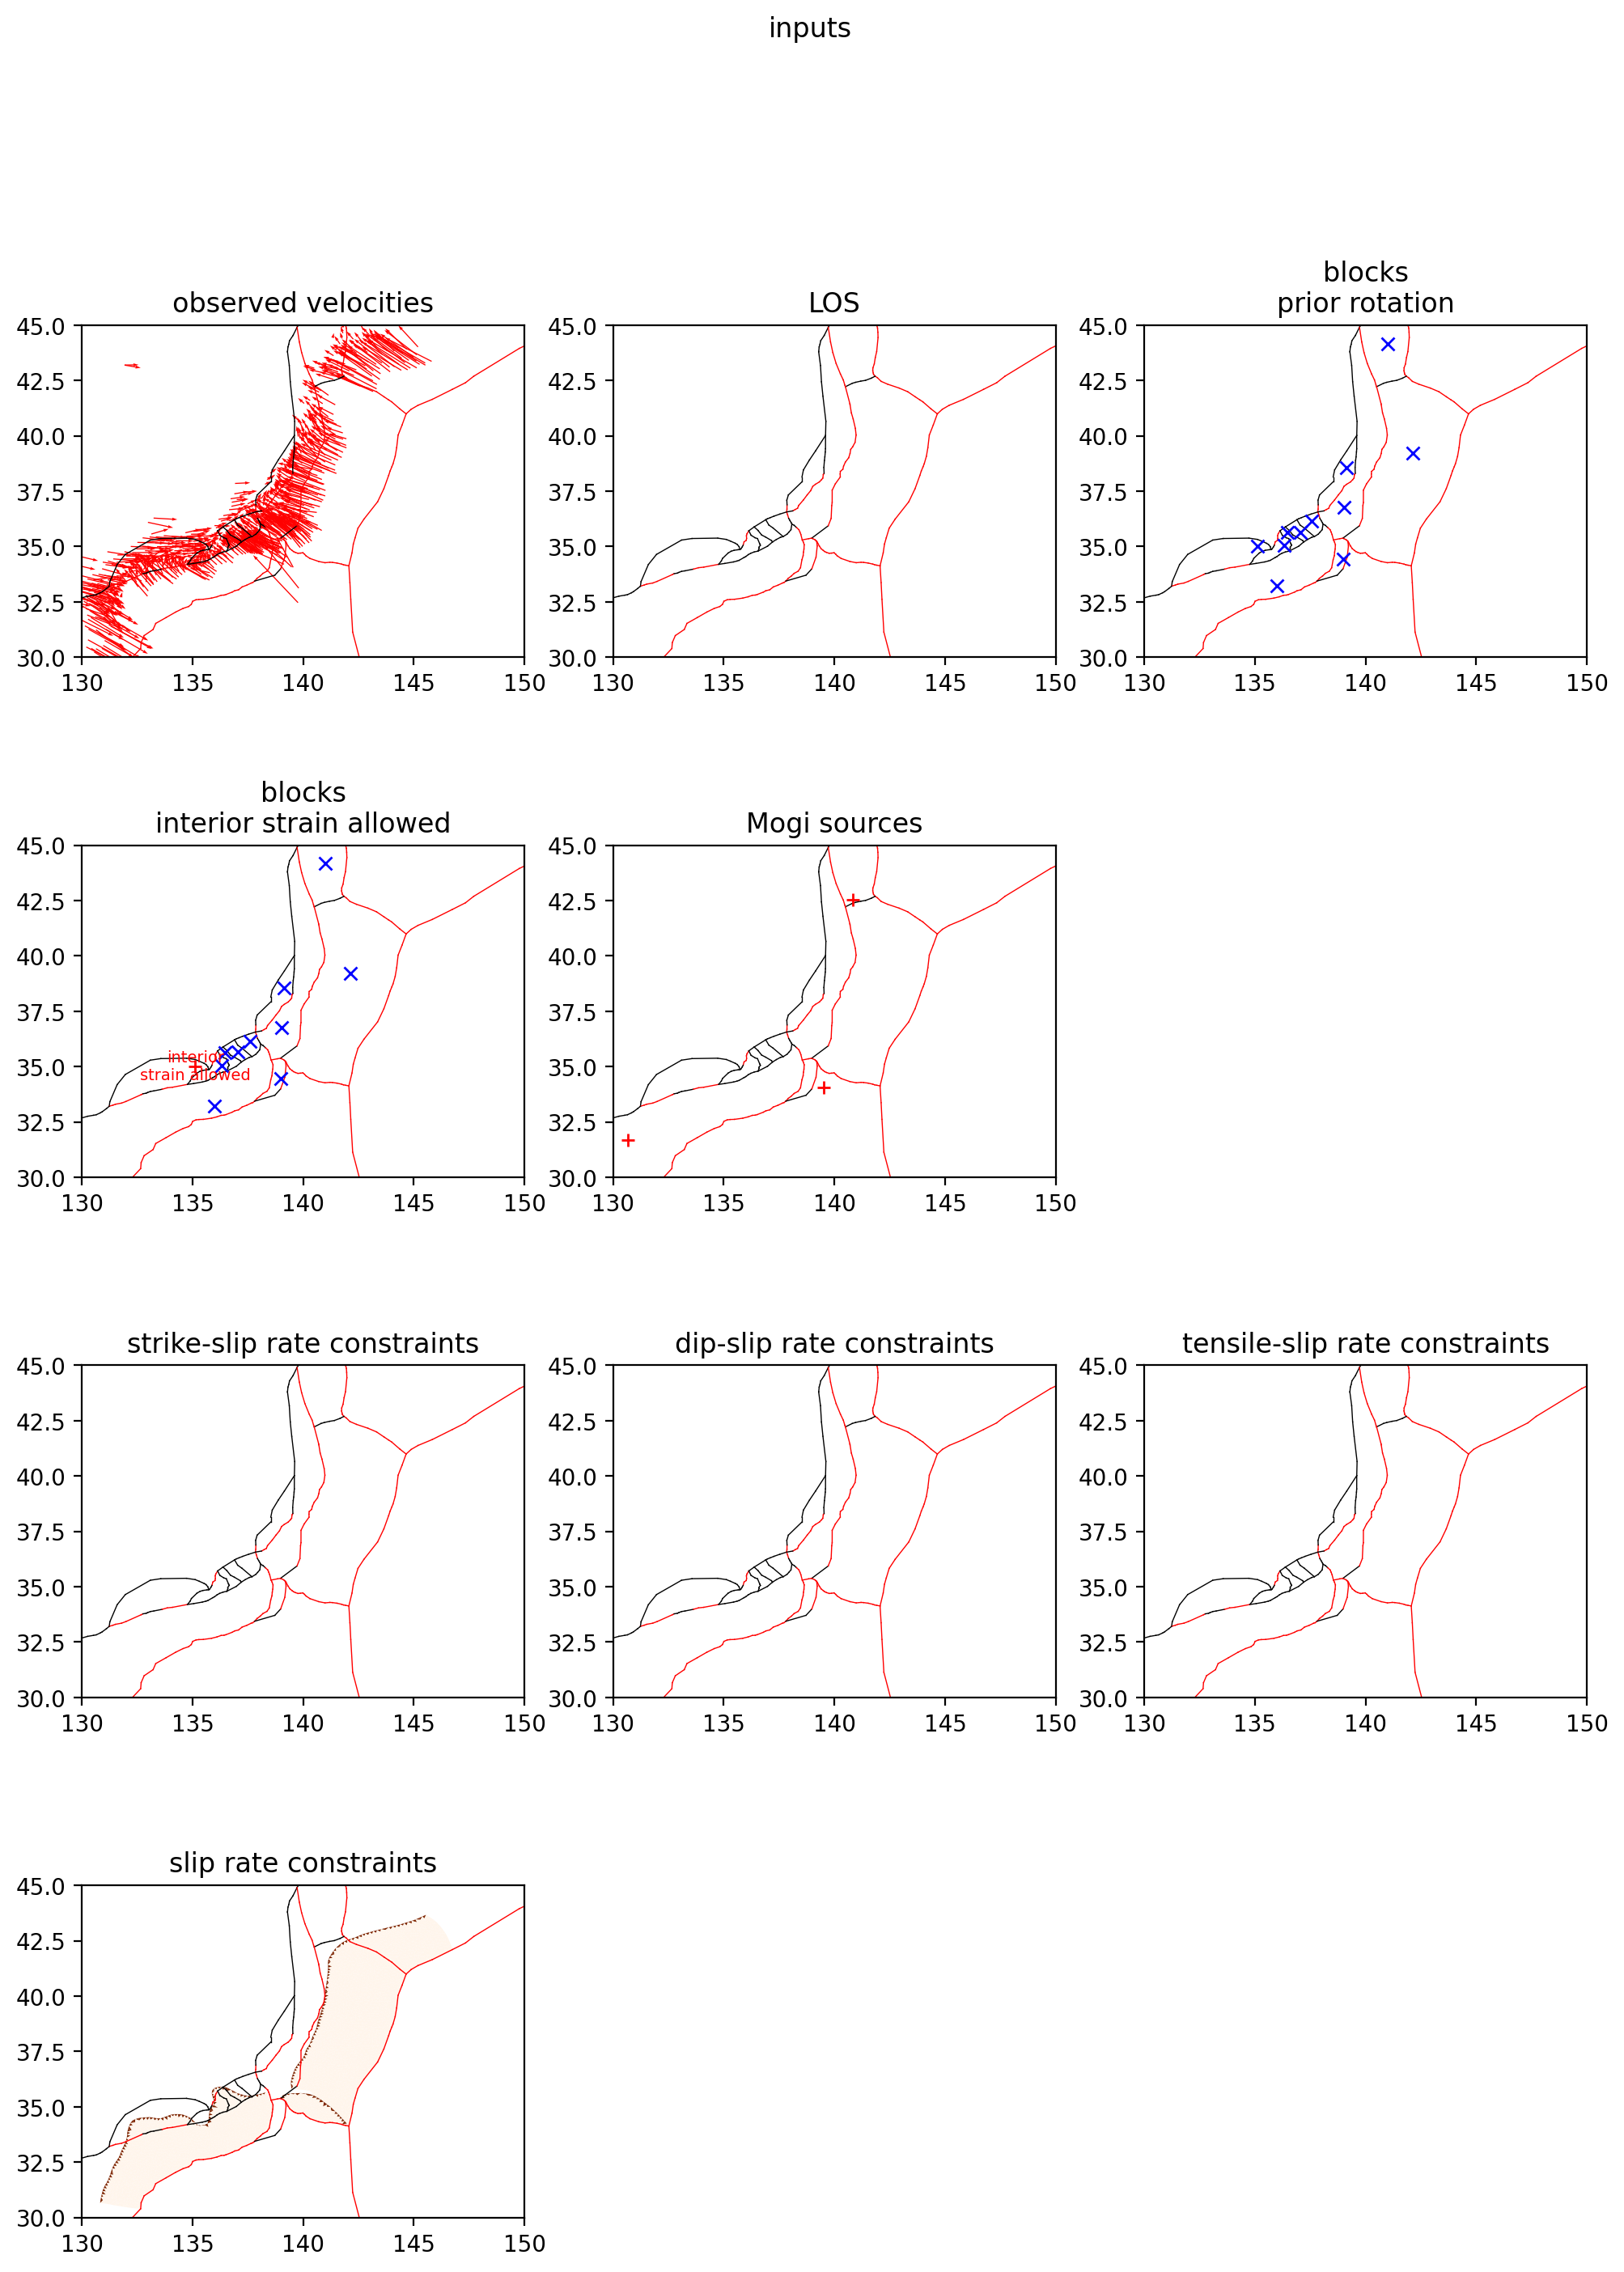

2024-10-25 15:58:55.395 | SUCCESS  | celeri.celeri:plot_input_summary:6207 - Wrote figures../runs/0000000107/plot_input_summary.(pdf, png)


<Figure size 640x480 with 0 Axes>

In [7]:
celeri.plot_input_summary(
    command,
    segment,
    station,
    block,
    meshes,
    mogi,
    sar,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=1e2,
)

# Sketching out the assembly of the block model system

$$
\begin{bmatrix}
    \mathrm{geodetic \; velocities} \\
    \mathrm{plate \; rotation \; constraints} \\
    \mathrm{slip \; rate \; constraints} \\
    \mathrm{TDE \; smoothing \; pseudodata = 0} \\
    \mathrm{TDE \; rate \; constraints} \\
    \mathrm{InSAR \; LOS \; changes} 
\end{bmatrix}
=
\begin{bmatrix}
    \mathrm{(rotations-elastic \; segments) \; to \; velocities} & \mathrm{TDEs \; to \; velocities} & \mathrm{block \; strain \; rate \; to \; velocities} & \mathrm{Mogi \; to \; velocities}\\
    \mathrm{identities}                                          & 0                                   & 0 \\
    \mathrm{plate \; rotations \; to \; slip \; rates}           & 0                                   & 0 \\
    0                                                            & \mathrm{TDE \; smoothing \; matrix} & 0 \\
    0                                                            & \mathrm{identities}                 & 0 \\
    \mathrm{(rotations-elastic \; segments) \; to \; LOS}        & \mathrm{TDEs \; to \; LOS}          & \mathrm{block \; strain \; rate \; to \; velocities}
\end{bmatrix}
\begin{bmatrix}
    \mathrm{plate \; rotation \; rates} \\
    \mathrm{TDE \; slip \; rates} \\
    \mathrm{block \; strain \; rates} \\
    \mathrm{Mogi \; rates}
\end{bmatrix}
$$

# Estimate block model parameters (dense)

In [9]:
index, estimation = celeri.assemble_and_solve_dense(
    command,
    assembly,
    operators,
    station,
    block,
    meshes,
    mogi,
)
celeri.post_process_estimation(estimation, operators, station, index)
celeri.write_output(command, estimation, station, segment, block, meshes)

TypeError: build_and_solve_dense() takes 4 positional arguments but 7 were given

# Plot model summary

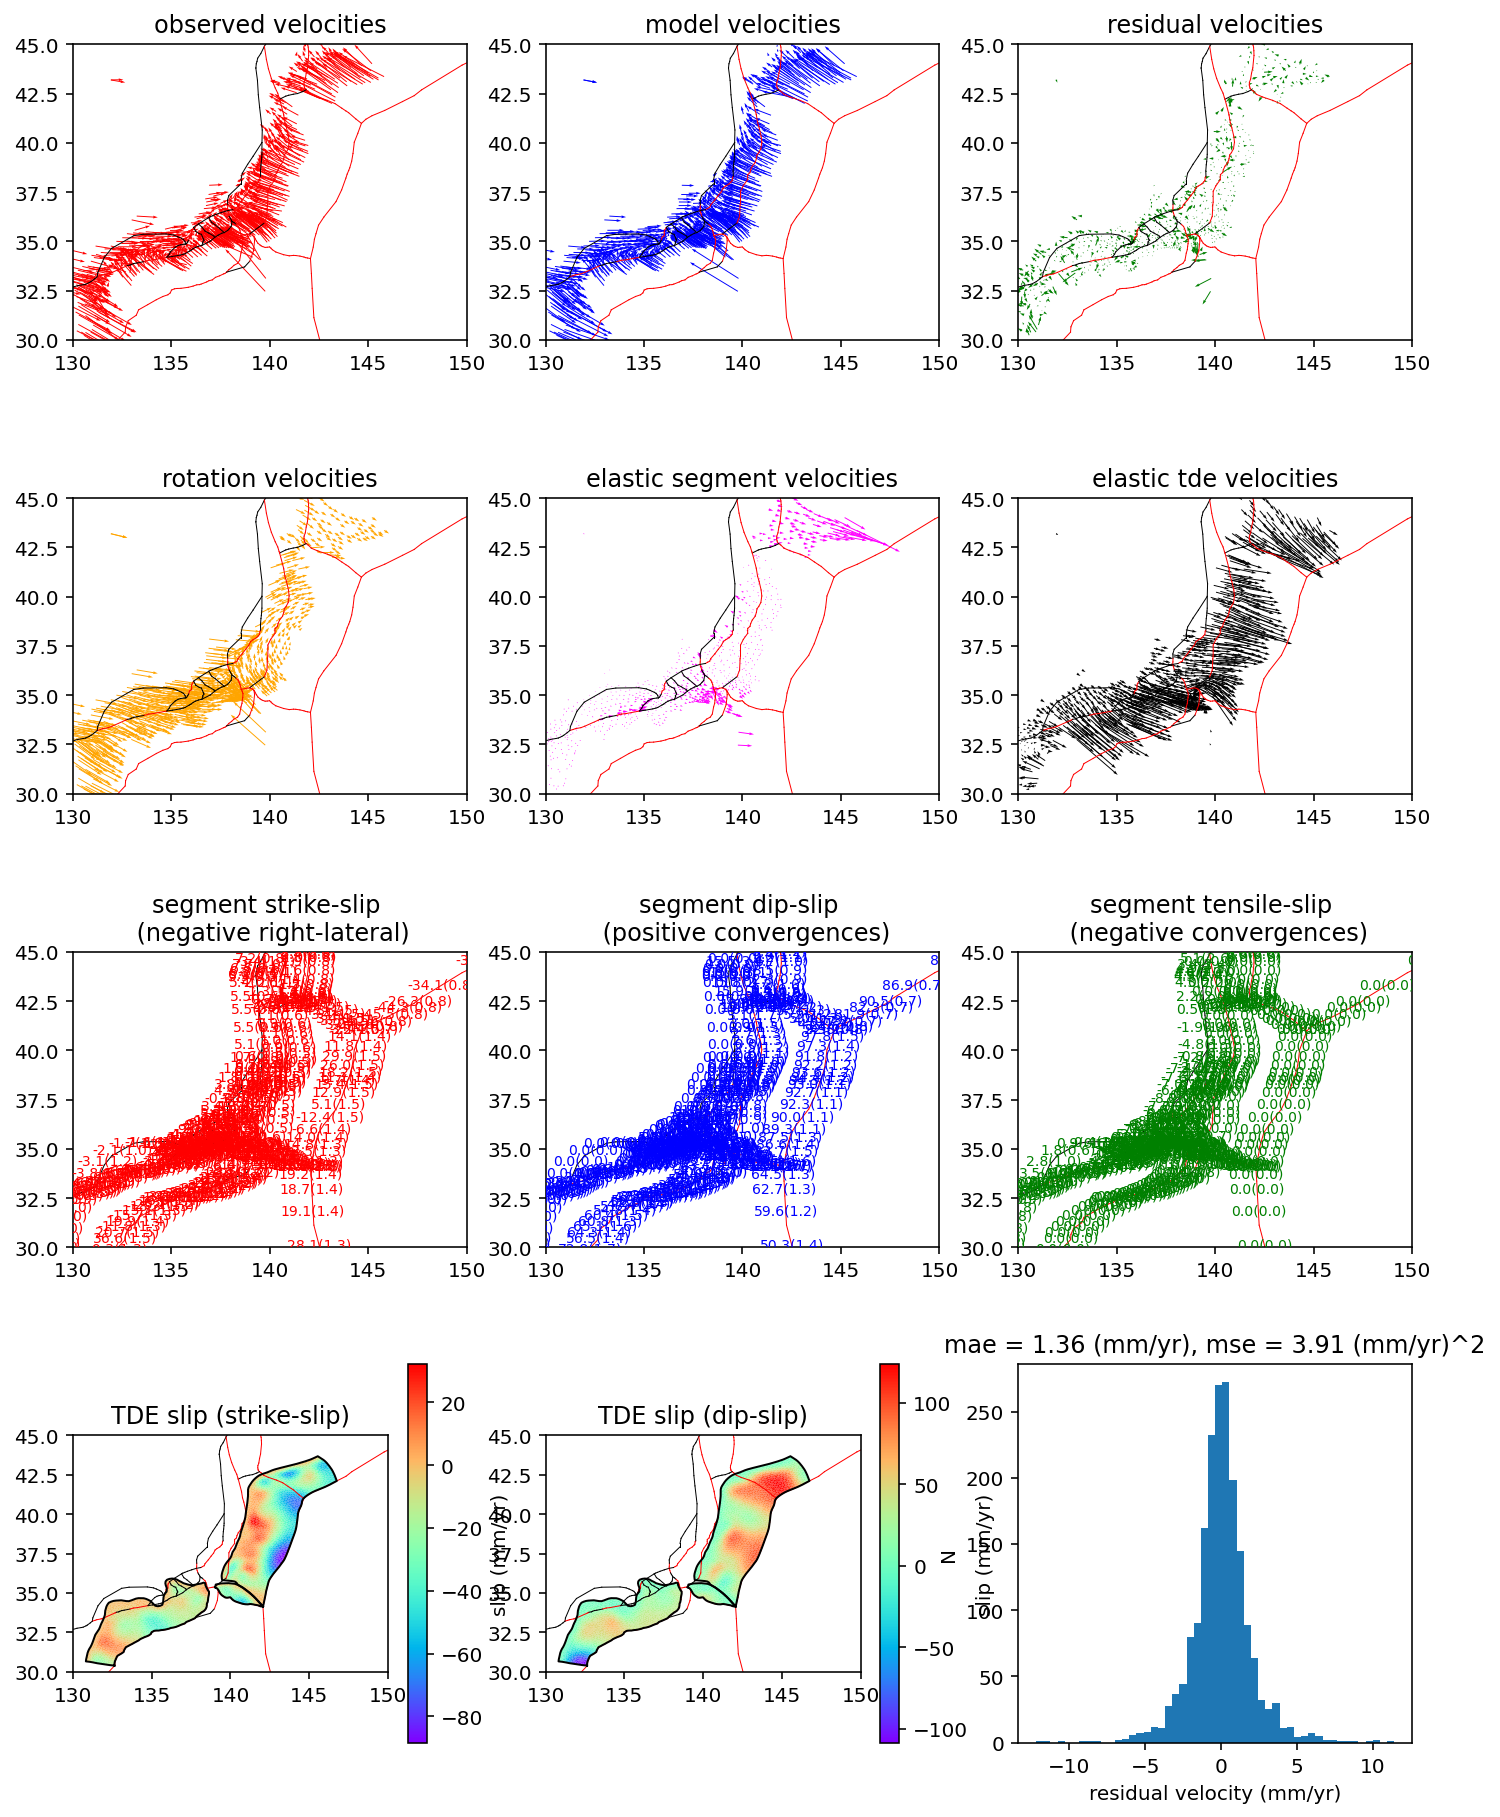

2024-07-12 00:11:10.354 | SUCCESS  | celeri.celeri:plot_estimation_summary:5528 - Wrote figures../runs/0000000009/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [10]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=1e2,
)

In [12]:
# np.savez(
#     "test_japan_arrays.npz",
#     estimation_slip_rates=estimation.slip_rates,
#     estimation_tde_rates=estimation.tde_rates,
#     estimation_east_vel_residual=estimation.east_vel_residual,
#     estimation_north_vel_residual=estimation.north_vel_residual,
# )

# testing_japan_arrays = np.load("test_japan_arrays.npz")
# assert np.allclose(estimation.slip_rates, testing_japan_arrays["estimation_slip_rates"])
# assert np.allclose(estimation.tde_rates, testing_japan_arrays["estimation_tde_rates"])
# assert np.allclose(
#     estimation.east_vel_residual,
#     testing_japan_arrays["estimation_east_vel_residual"],
# )
# assert np.allclose(
#     estimation.north_vel_residual,
#     testing_japan_arrays["estimation_north_vel_residual"],
# )